# NYC Health Inspections


# Pre-Requisites:
    1. Install Sodapy - $ pip install sodapy
    2. Install GeoPandas - "conda install geopandas"
    3. Download boundaries for NYC zip codes and place on "Project-1" folder "https://data.cityofnewyork.us/Business/Zip-Code-Boundaries/i8iw-xf4u"

In [ ]:
import pandas as pd
import numpy as np
import requests
import json

# Import API key
from config import gkey

#import sys
#!{sys.executable} -m pip install sodapy 

In [72]:
from sodapy import Socrata
client = Socrata("data.cityofnewyork.us", None)
results = client.get("43nn-pn8j", limit=300000)
results_df = pd.DataFrame.from_records(results)
results_df.count()
results_df.to_csv('smallpractice_data.csv', index=True)

In [73]:
#Read imported datafile
results_df.head(2)

,action,boro,building,camis,critical_flag,cuisine_description,dba,grade,grade_date,inspection_date,inspection_type,phone,record_date,score,street,violation_code,violation_description,zipcode
0,Violations were cited in the following area(s).,BRONX,1007,30075445,Critical,Bakery,MORRIS PARK BAKE SHOP,NaN,NaN,2019-05-16T00:00:00.000,Cycle Inspection / Initial Inspection,7188924968,2019-06-09T06:01:00.000,18,MORRIS PARK AVE,04L,Evidence of mice or live mice present in facil...,10462
1,Violations were cited in the following area(s).,BRONX,1007,30075445,Not Critical,Bakery,MORRIS PARK BAKE SHOP,NaN,NaN,2019-05-16T00:00:00.000,Cycle Inspection / Initial Inspection,7188924968,2019-06-09T06:01:00.000,18,MORRIS PARK AVE,08A,Facility not vermin proof. Harborage or condit...,10462


# Step 1: Clean Data

In [75]:
# Drop Duplicate restaurant data
restaurantDensity = results_df.drop_duplicates(subset=['zipcode','boro','dba','cuisine_description','phone','street'])

#Get Restaurant Weight per zip code
restaurantDensity = restaurantDensity.groupby("zipcode").agg({'zipcode':'count'})
restaurantDensity = restaurantDensity.rename(columns = {"zipcode" : "RestaurantCount"})
restaurantDensity['RestaurantWeight']=restaurantDensity['RestaurantCount']/sum(restaurantDensity['RestaurantCount'])*100
restaurantDensity['RestaurantWeight']=restaurantDensity['RestaurantWeight'].map("{:.2f}".format)
restaurantDensity = restaurantDensity.reset_index(level=['zipcode'])
print(sum(restaurantDensity['RestaurantCount']))
restaurantDensity.head(5)

17052


,zipcode,RestaurantCount,RestaurantWeight
0,10000,2,0.01
1,10001,311,1.82
2,10002,280,1.64
3,10003,446,2.62
4,10004,104,0.61


In [93]:
from geopandas import GeoDataFrame

# Import and read zipcode files

zip_codesData = GeoDataFrame.from_file('ZIP_CODE_040114/ZIP_CODE_040114.shp') #read in shape file
zip_codesData['ZIPCODE'] = zip_codesData['ZIPCODE'].astype(int) #converting zipcode column to integer data type
zip_codesData = zip_codesData.rename(columns = {"ZIPCODE" : "zip_code"})

restaurantDensityUpdated=GeoDataFrame(restaurantDensity)
restaurantDensityUpdated = restaurantDensityUpdated.rename(columns = {"zipcode" : "zip_code"})

#print(type(zip_codesData))
#print(type(restaurantDensityUpdated))

restaurantDensityUpdated['zip_code'] = restaurantDensityUpdated['zip_code'].astype(int)

restaurantDensityUpdated.head()

,zip_code,RestaurantCount,RestaurantWeight
0,10000,2,0.01
1,10001,311,1.82
2,10002,280,1.64
3,10003,446,2.62
4,10004,104,0.61


In [94]:
# Merge restaurant Density DF with GeoDataFrame zipcode file
restaurantDensityUpdated = GeoDataFrame(restaurantDensityUpdated.merge(zip_codesData, how='right', 
                                                                       left_on='zip_code', right_on='zip_code'))
restaurantDensityUpdated= restaurantDensityUpdated.dropna() #drop null values
restaurantDensityUpdated.head(2)

,zip_code,RestaurantCount,RestaurantWeight,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,10001,311.0,1.82,0,New York,22413.0,1.779494e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((981958.6472873986 213464.4530421346,..."
1,10002,280.0,1.64,0,New York,81305.0,2.628013e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((991339.8703228086 207576.7837151289,..."


# Percentage of Restaurant by Zipcode

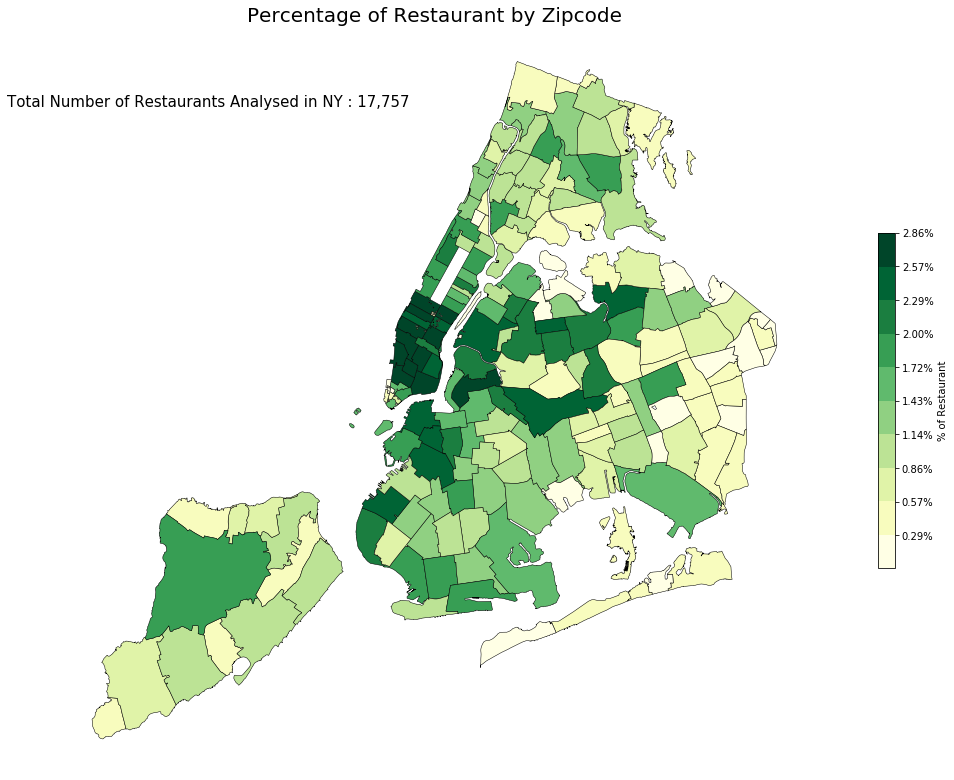

In [77]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
#import seaborn as sns


#ColorSchems: OrRd,seismic,viridis,RdYlBu,coolwarm,hot,YlGn

numOfcolorGradation = 10
chartSize = 15
colorScheme = 'YlGn'
edgeColorValue = 'black'
boundaryLineWidth = 0.5

cmap = plt.cm.get_cmap(colorScheme, numOfcolorGradation)

fig, ax = plt.subplots(figsize = (chartSize,chartSize))
zz_Chart = restaurantDensityUpdated.plot(column='RestaurantWeight', 
                                 cmap=cmap,
                                 alpha=1,
                                 linewidth=boundaryLineWidth, 
                                 ax=ax,
                                 edgecolor=edgeColorValue)


sm = plt.cm.ScalarMappable(cmap=cmap,norm=plt.Normalize(min(restaurantDensityUpdated.RestaurantWeight),
                                                        max(restaurantDensityUpdated.RestaurantWeight)))


ticksVal=np.linspace(start=0, stop=float(max(restaurantDensityUpdated['RestaurantWeight'].values)), 
                     num=numOfcolorGradation+1)

plt.colorbar(sm,
             ax=ax,
             fraction=0.02, 
             pad=0.08, 
             label='% of Restaurant',
             ticks=ticksVal,
            format=StrMethodFormatter('{x:,.2f}%'))

plt.title('Percentage of Restaurant by Zipcode', size=20)
plt.axis('off')

plt.text(0.2, 0.9,
         s='Total Number of Restaurants Analysed in NY : ' + 
         str(format(int(sum(restaurantDensityUpdated['RestaurantCount'].values)),',d')), 
         ha='center', va='center', transform=ax.transAxes, size=15)

plt.savefig('Percentage_Restaurants_by_Zipcode.png')
plt.show()


In [31]:
# Graph 4: scatter plot, Y= grades, x = cuisines
## Bin grades into integers (6=A, 5=B, 4=C, etc), and average them per cuisine. Label points.

In [32]:
# Graph 4b: scatter plot, Y= closures, x = cuisines
# count of closures by cuisine. Label points.

In [33]:
# Graph 5: heatmap of inspections per zipcode
# delete entries without inspections or zipcodes

In [34]:
# Graph 6: Bargraph of closures and reclosures by borough
# count closures, count reclosures, group by borough

In [87]:
#Filtering DataFrame for Close and Reclosure Restaurant
ClosuresDF = results_df[results_df['action'].str.contains('losed by DOHMH')]
ClosuresDF = ClosuresDF.drop_duplicates(subset=['zipcode','boro','dba','cuisine_description','phone','street'])
TotalClosures = len(ClosuresDF)

ClosuresDF = ClosuresDF.groupby("zipcode").agg({'zipcode':'count'})
ClosuresDF = ClosuresDF.rename(columns = {"zipcode" : "ClosuresDFCount"})
ClosuresDF['ClosuresDFWeight']=ClosuresDF['ClosuresDFCount']/TotalClosures*100
ClosuresDF['ClosuresDFWeight']=ClosuresDF['ClosuresDFWeight'].map("{:.2f}".format)
ClosuresDF = ClosuresDF.reset_index(level=['zipcode'])
ClosuresDF.head(5)

,zipcode,ClosuresDFCount,ClosuresDFWeight
0,10001,18,1.10
1,10002,42,2.57
2,10003,39,2.39
3,10004,6,0.37
4,10005,4,0.24


In [88]:
#Converting DF to GeoDataFrame
ClosuresDFUpdated=GeoDataFrame(ClosuresDF)
ClosuresDFUpdated = ClosuresDFUpdated.rename(columns = {"zipcode" : "zip_code"})

#print(type(zip_codesData))
#print(type(restaurantDensityUpdated))

# Merge Closure Restaurants DF with GeoDataFrame zipcode file
ClosuresDFUpdated['zip_code'] = ClosuresDFUpdated['zip_code'].astype(int)
ClosuresDFUpdated = GeoDataFrame(ClosuresDFUpdated.merge(zip_codesData, how='right', 
                                                                       left_on='zip_code', right_on='zip_code'))
ClosuresDFUpdated= ClosuresDFUpdated.dropna() #drop null values
ClosuresDFUpdated.head(2)


,zip_code,ClosuresDFCount,ClosuresDFWeight,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,10001,18.0,1.10,0,New York,22413.0,1.779494e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((981958.6472873986 213464.4530421346,..."
1,10002,42.0,2.57,0,New York,81305.0,2.628013e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((991339.8703228086 207576.7837151289,..."


# Percentage of Restaurant Closures by Zipcode

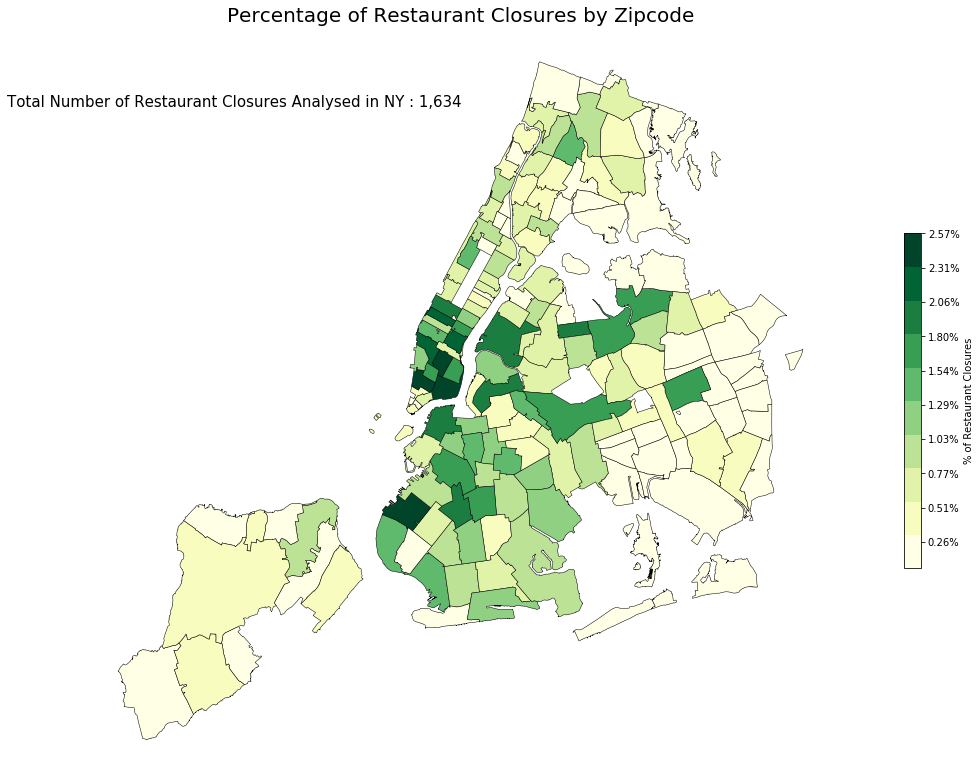

In [78]:
#Plotting the data
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
#import seaborn as sns


#ColorSchems: OrRd,seismic,viridis,RdYlBu,coolwarm,hot,YlGn

numOfcolorGradation = 10
chartSize = 15
colorScheme = 'YlGn'
edgeColorValue = 'black'
boundaryLineWidth = 0.5

cmap = plt.cm.get_cmap(colorScheme, numOfcolorGradation)

fig, ax = plt.subplots(figsize = (chartSize,chartSize))
zz_Chart2 = ClosuresDFUpdated.plot(column='ClosuresDFWeight', 
                                 cmap=cmap,
                                 alpha=1,
                                 linewidth=boundaryLineWidth, 
                                 ax=ax,
                                 edgecolor=edgeColorValue)


sm = plt.cm.ScalarMappable(cmap=cmap,norm=plt.Normalize(min(ClosuresDFUpdated.ClosuresDFWeight),
                                                        max(ClosuresDFUpdated.ClosuresDFWeight)))


ticksVal=np.linspace(start=0, stop=float(max(ClosuresDFUpdated['ClosuresDFWeight'].values)), 
                     num=numOfcolorGradation+1)

plt.colorbar(sm,
             ax=ax,
             fraction=0.02, 
             pad=0.08, 
             label='% of Restaurant Closures',
             ticks=ticksVal,
            format=StrMethodFormatter('{x:,.2f}%'))

plt.title('Percentage of Restaurant Closures by Zipcode', size=20)
plt.axis('off')

plt.text(0.2, 0.9,
         s='Total Number of Restaurant Closures Analysed in NY : ' + 
         str(format(int(TotalClosures),',d')), 
         ha='center', va='center', transform=ax.transAxes, size=15)

plt.savefig('Percentage_Restaurant_Closures_by_Zipcode.png')
plt.show()


In [90]:
#Get CriticalViolations Weight per zip code

CriticalViolations = results_df[results_df.critical_flag=='Critical']
TotalCriticalViolations = len(CriticalViolations)

CriticalViolationsDensity = CriticalViolations.groupby("zipcode").agg({'zipcode':'count'})
CriticalViolationsDensity = CriticalViolationsDensity.rename(columns = {"zipcode" : "CriticalViolationCount"})
CriticalViolationsDensity['CriticalViolationWeight']=CriticalViolationsDensity['CriticalViolationCount']/TotalCriticalViolations*100
CriticalViolationsDensity['CriticalViolationWeight']=CriticalViolationsDensity['CriticalViolationWeight'].map("{:.2f}".format)
CriticalViolationsDensity = CriticalViolationsDensity.reset_index(level=['zipcode'])
CriticalViolationsDensity.head(5)

,zipcode,CriticalViolationCount,CriticalViolationWeight
0,10000,15,0.01
1,10001,2944,1.80
2,10002,3167,1.94
3,10003,4284,2.62
4,10004,842,0.51


In [95]:
#Converting DF to GeoDataFrame

CriticalViolationsDensityUpdated=GeoDataFrame(CriticalViolationsDensity)
CriticalViolationsDensityUpdated = CriticalViolationsDensityUpdated.rename(columns = {"zipcode" : "zip_code"})

#print(type(zip_codesData))
#print(type(restaurantDensityUpdated))

#Merging GeoDataFrame with Critical Violations Density DF


CriticalViolationsDensityUpdated['zip_code'] = CriticalViolationsDensityUpdated['zip_code'].astype(int)
CriticalViolationsDensityUpdated = GeoDataFrame(CriticalViolationsDensityUpdated.merge(zip_codesData, how='right', 
                                                                       left_on='zip_code', right_on='zip_code'))
CriticalViolationsDensityUpdated= CriticalViolationsDensityUpdated.dropna() #drop null values
CriticalViolationsDensityUpdated.head(2)

,zip_code,CriticalViolationCount,CriticalViolationWeight,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,10001,2944.0,1.80,0,New York,22413.0,1.779494e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((981958.6472873986 213464.4530421346,..."
1,10002,3167.0,1.94,0,New York,81305.0,2.628013e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((991339.8703228086 207576.7837151289,..."


# Percentage of Critical Violations by Zipcode

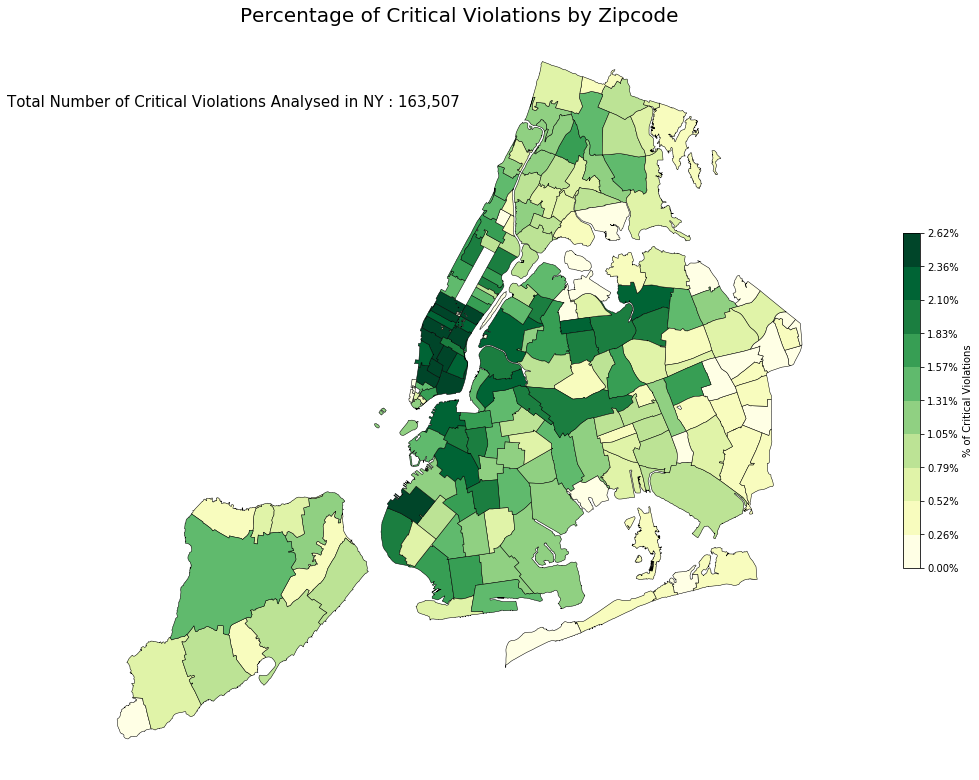

In [79]:
#Plotting the data
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
#import seaborn as sns


#ColorSchems: OrRd,seismic,viridis,RdYlBu,coolwarm,hot,YlGn

numOfcolorGradation = 10
chartSize = 15
colorScheme = 'YlGn'
edgeColorValue = 'black'
boundaryLineWidth = 0.5

cmap = plt.cm.get_cmap(colorScheme, numOfcolorGradation)

fig, ax = plt.subplots(figsize = (chartSize,chartSize))
zz_Chart2 = CriticalViolationsDensityUpdated.plot(column='CriticalViolationWeight', 
                                 cmap=cmap,
                                 alpha=1,
                                 linewidth=boundaryLineWidth, 
                                 ax=ax,
                                 edgecolor=edgeColorValue)


sm = plt.cm.ScalarMappable(cmap=cmap,norm=plt.Normalize(min(CriticalViolationsDensityUpdated.CriticalViolationWeight),
                                                        max(CriticalViolationsDensityUpdated.CriticalViolationWeight)))


ticksVal=np.linspace(start=0, stop=float(max(CriticalViolationsDensityUpdated['CriticalViolationWeight'].values)), 
                     num=numOfcolorGradation+1)

plt.colorbar(sm,
             ax=ax,
             fraction=0.02, 
             pad=0.08, 
             label='% of Critical Violations',
             ticks=ticksVal,
            format=StrMethodFormatter('{x:,.2f}%'))

plt.title('Percentage of Critical Violations by Zipcode', size=20)
plt.axis('off')

plt.text(0.2, 0.9,
         s='Total Number of Critical Violations Analysed in NY : ' + 
         str(format(int(TotalCriticalViolations),',d')), 
         ha='center', va='center', transform=ax.transAxes, size=15)

plt.savefig('Percentage_Critical_Violations_by_Zipcode.png')
plt.show()


In [92]:
#Merging Restaurant Density DF and CriticalViolationsDensity DF

CriticalViolationsDensity

CViolperRest = pd.merge(restaurantDensity[['zipcode','RestaurantCount']],
                        CriticalViolationsDensity[['zipcode','CriticalViolationCount']], 
                        how='left',left_on=['zipcode'],right_on=['zipcode'])
CViolperRest['CVperRest']=CViolperRest['CriticalViolationCount']/CViolperRest['RestaurantCount']
# Fill 0's for null rows
CViolperRest.fillna(0, inplace=True)
CViolperRest.head(5)
#CViolperRest.to_csv('CViolperRest.csv',index=True,header=True)

,zipcode,RestaurantCount,CriticalViolationCount,CVperRest
0,10000,2,15.0,7.500000
1,10001,311,2944.0,9.466238
2,10002,280,3167.0,11.310714
3,10003,446,4284.0,9.605381
4,10004,104,842.0,8.096154


In [ ]:
#Converting DF to GeoDataFrame

CViolperRestUpdated=GeoDataFrame(CViolperRest)
CViolperRestUpdated = CViolperRestUpdated.rename(columns = {"zipcode" : "zip_code"})

#print(type(zip_codesData))
#print(type(restaurantDensityUpdated))

#Merging GeoDataFrame with Critical Violations Per Restaurant

CViolperRestUpdated['zip_code'] = CViolperRestUpdated['zip_code'].astype(int)
CViolperRestUpdated = GeoDataFrame(CViolperRestUpdated.merge(zip_codesData, how='right', 
                                                                       left_on='zip_code', right_on='zip_code'))
CViolperRestUpdated= CViolperRestUpdated.dropna() #drop null values
CViolperRestUpdated.head(2)

# Average Critical Violations per Restaurant by Zipcode

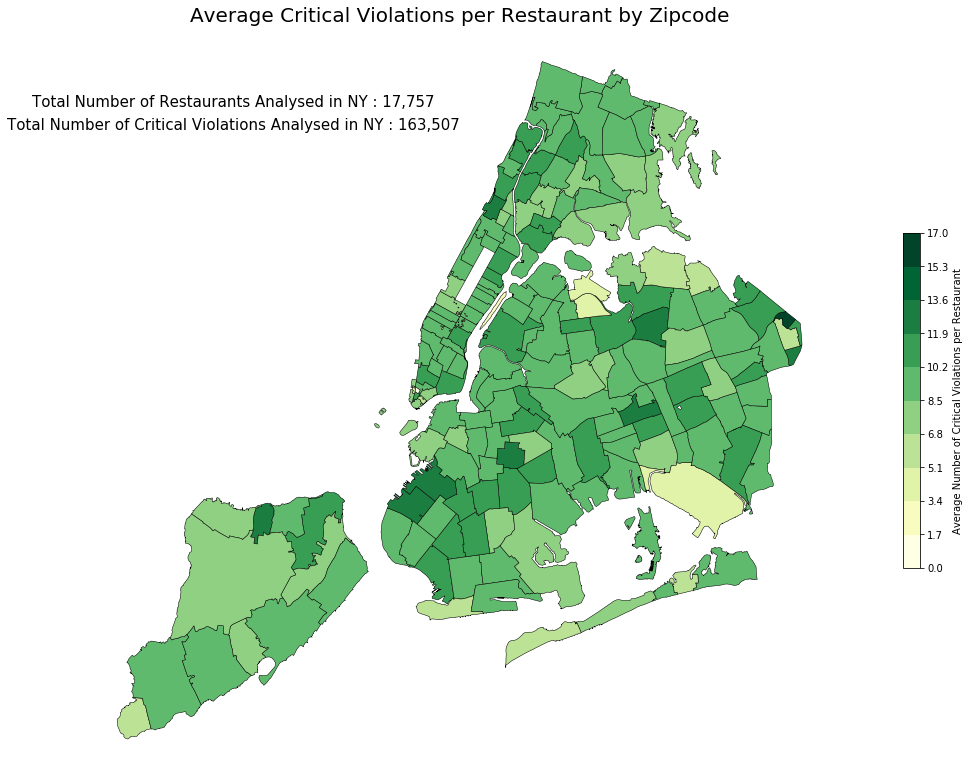

In [80]:
#Plotting the data
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
#import seaborn as sns


#ColorSchems: OrRd,seismic,viridis,RdYlBu,coolwarm,hot,YlGn

numOfcolorGradation = 10
chartSize = 15
colorScheme = 'YlGn'
edgeColorValue = 'black'
boundaryLineWidth = 0.5

cmap = plt.cm.get_cmap(colorScheme, numOfcolorGradation)

fig, ax = plt.subplots(figsize = (chartSize,chartSize))
zz_Chart2 = CViolperRestUpdated.plot(column='CVperRest', 
                                 cmap=cmap,
                                 alpha=1,
                                 linewidth=boundaryLineWidth, 
                                 ax=ax,
                                 edgecolor=edgeColorValue)


sm = plt.cm.ScalarMappable(cmap=cmap,norm=plt.Normalize(min(CViolperRestUpdated.CVperRest),
                                                        max(CViolperRestUpdated.CVperRest)))


ticksVal=np.linspace(start=0, stop=float(max(CViolperRestUpdated['CVperRest'].values)), 
                     num=numOfcolorGradation+1)

plt.colorbar(sm,
             ax=ax,
             fraction=0.02, 
             pad=0.08, 
             label='Average Number of Critical Violations per Restaurant',
             ticks=ticksVal,
            format=StrMethodFormatter('{x:,.1f}'))

plt.title('Average Critical Violations per Restaurant by Zipcode', size=20)
plt.axis('off')

plt.text(0.2, 0.9,
         s='Total Number of Restaurants Analysed in NY : ' + 
         str(format(int(sum(restaurantDensityUpdated['RestaurantCount'].values)),',d')), 
         ha='center', va='center', transform=ax.transAxes, size=15)
plt.text(0.2, 0.87,
         s='Total Number of Critical Violations Analysed in NY : ' + 
         str(format(int(TotalCriticalViolations),',d')), 
         ha='center', va='center', transform=ax.transAxes, size=15)

plt.savefig('Critical_Violations_per_Restaurant_by_Zipcode.png')
plt.show()


In [25]:
# Graph 8: heatmap of grades by zipcode or scatterplot by cuisine
# describes best and worst zipcodes, shows good/bad restaurants by cuisine

In [37]:
#Graph 9: bargraph showing inspections per year, closures per year
 

In [38]:
# Analysis??? Opportunities for Regressions, chi-squares?